<H1>Construcción de la red </H1>

In [30]:
from ast import literal_eval

import numpy as np
import pandas as pd
from numpy import ndarray

df = pd.read_csv('ReformaPensional.csv')
df

,id,text,created_at,conversation_id,geo,public_metrics,context_annotations,entities,author_id,author_username,in_reply_to_user_id,ref_id,ref_type,ref_author_id,ref_author,ref_text,ref_note_tweet
0,1804665614599946262,@petrogustavo Ahora son los ancianos la CORTIN...,2024-06-22 23:59:46+00:00,1804010291807564057,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[{'domain': {'id': '10', 'name': 'Person', 'de...","{'mentions': [{'start': 0, 'end': 13, 'usernam...",1251157214393294860,JULIOTORRESB3,4.984973e+07,1.804010e+18,replied_to,4.984973e+07,petrogustavo,No entiendo la inquina contra millones de anci...,No entiendo la inquina contra millones de anci...
1,1804665600654139443,RT @ThomasitaD: Se oponen a la reforma pension...,2024-06-22 23:59:42+00:00,1804665600654139443,NaN,"{'retweet_count': 37, 'reply_count': 0, 'like_...",[],"{'mentions': [{'start': 3, 'end': 14, 'usernam...",64481112,CURTlSEOso,NaN,1.804549e+18,retweeted,1.565113e+18,ThomasitaD,Se oponen a la reforma pensional que le ofrece...,NaN
2,1804665589816045976,RT @petrogustavo: A llenar la plaza de Bolívar...,2024-06-22 23:59:40+00:00,1804665589816045976,NaN,"{'retweet_count': 3585, 'reply_count': 0, 'lik...","[{'domain': {'id': '10', 'name': 'Person', 'de...","{'mentions': [{'start': 3, 'end': 16, 'usernam...",257212908,defrankns,NaN,1.804601e+18,retweeted,4.984973e+07,petrogustavo,A llenar la plaza de Bolívar con la tercera ed...,NaN
3,1804665552348352909,RT @RobertoMTico: No era éste👇payaso de David ...,2024-06-22 23:59:31+00:00,1804665552348352909,NaN,"{'retweet_count': 248, 'reply_count': 0, 'like...","[{'domain': {'id': '10', 'name': 'Person', 'de...","{'mentions': [{'start': 3, 'end': 16, 'usernam...",1475562865524416513,HectorA87524815,NaN,1.804477e+18,retweeted,1.105978e+18,RobertoMTico,"No era éste👇payaso de David Luna, junto con el...",NaN
4,1804665515912089658,RT @willj84753699: ¡ATENCIÓN COLOMBIA!\nAmigos...,2024-06-22 23:59:22+00:00,1804665515912089658,NaN,"{'retweet_count': 292, 'reply_count': 0, 'like...","[{'domain': {'id': '10', 'name': 'Person', 'de...","{'mentions': [{'start': 3, 'end': 17, 'usernam...",145465610,alperezv,NaN,1.804654e+18,retweeted,1.002603e+18,willj84753699,"¡ATENCIÓN COLOMBIA!\nAmigos, vamos con este ll...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,1806875966637003070,Ya me llegó el comunicado de Colfondos … la Re...,2024-06-29 02:22:55+00:00,1806875966637003070,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[],"{'annotations': [{'start': 29, 'end': 37, 'pro...",101057155,azukittamami,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2484,1806872236348850347,@LauraWillsO @CongresoVisible @CPolUniandes @f...,2024-06-29 02:08:05+00:00,1806783063424401500,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[],"{'mentions': [{'start': 0, 'end': 12, 'usernam...",1205960500829401095,Blochh16,1.205961e+18,1.806870e+18,replied_to,1.205961e+18,Blochh16,@LauraWillsO @CongresoVisible @CPolUniandes @f...,NaN
2485,1806871943326364065,@FulanoZuluaga Apreciado Juan P. Aunque yo he ...,2024-06-29 02:06:56+00:00,1806817302513623487,NaN,"{'retweet_count': 0, 'reply_count': 2, 'like_c...",[],"{'mentions': [{'start': 0, 'end': 14, 'usernam...",1506101463554134020,ESaenzRovner,3.532394e+09,1.806848e+18,replied_to,3.532394e+09,FulanoZuluaga,@ESaenzRovner Los fondos de ahorro pensional s...,NaN
2486,1806871539842699701,1.El Guerrillero Presidente anuncia para el 20...,2024-06-29 02:05:19+00:00,1806871539842699701,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[],"{'urls': [{'start': 281, 'end': 304, 'url': 'h...",1478408845726789639,manuel_pascuas,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df['geo'] = df['geo'].fillna("{}")
df['entities'] = df['entities'].fillna("{}")
df['in_reply_to_user_id'] = df['in_reply_to_user_id'].fillna(0)
df['ref_id'] = df['ref_id'].fillna(0)
df['ref_type'] = df['ref_type'].fillna("tweeted")
df['ref_author_id'] = df['ref_author_id'].fillna(0)
df['ref_author'] = df['ref_author'].fillna("")
df['ref_text'] = df['ref_text'].fillna("")
df['ref_note_tweet'] = df['ref_note_tweet'].fillna("")
df.isnull().sum()

id                     0
text                   0
created_at             0
conversation_id        0
geo                    0
public_metrics         0
context_annotations    0
entities               0
author_id              0
author_username        0
in_reply_to_user_id    0
ref_id                 0
ref_type               0
ref_author_id          0
ref_author             0
ref_text               0
ref_note_tweet         0
dtype: int64

In [32]:
def getMentionsList(tweet_entities) -> list[str]:
    return [mention['username'] for mention in literal_eval(tweet_entities).get("mentions", [])]


users: set[str] = set(np.concatenate((df['author_username'].unique(), df['ref_author'].unique())))

for tweet_entities in df['entities']:
    users.update(getMentionsList(tweet_entities))
users.discard("")

print(users, len(users))

{'LondonoLen81165', 'ivansan', 'gesuriberg', 'Ricrod18', 'XaraTormenta', 'ExtraColombia', 'AngaritaVergara', 'ESaenzRovner', 'Intidelaho2', 'SarayGonzalez95', 'jsanchezcristo', 'Juapa95973399', 'edwinespinosaqu', 'RicardboDiaz', 'nestorleons', 'nicocarreb', 'cirotrujillo22', 'ArrolloKei54910', 'tides001', 'LUISBERNARDOFI5', 'AnguloR0511', 'metmet754849', 'CarlosTorresVel', 'mvelezjara67', 'Morajhon14', 'LuisMan81373260', 'Rios53Rios', 'ivandaal2004', 'UsolidariaCo', 'LuzMarinaVelsq5', 'Karibeno721179', 'lcvelez', 'dfdfaff865144b3', 'gabopensante', 'Miguel646816961', 'cruaacevedo', 'forvismazarsco', 'sebastian0922', 'libertadavanza0', 'DuvalierSanchez', 'SrAngarita', 'omega682', 'SebastianNohra', 'Ricardo89439744', 'nicola19383', 'JohanSGamboa', 'jotace1604', 'LuisFerMu_', 'NoticiasRCN', 'ctccolombia', 'Juan_Florez', 'PactoHistorico', 'javierzabala', 'pensar12345', 'PauloCruman', 'elespectador', 'TICALANCHEROS', 'Reynald06597037', 'javierarc35', 'Antimamertussss', 'FreyreJaime', 'Mag_03

In [33]:
user_index: dict[str, int] = {user: idx for idx, user in enumerate(users)}
n: int = len(users)
mentions_matrix: ndarray[int] = np.zeros((n, n), dtype=int)
user_array = np.array(list(users))
for index, row in df.iterrows():
    author: str = row['author_username']  #usuario que escribió el tweet
    author_idx: int = user_index[author]
    mentions: set[str] = set(getMentionsList(row['entities']))

    if row['ref_author'] and row['ref_author'] not in mentions:
        mentions = mentions.union({row['ref_author']})

    for mentioned_user in mentions:
        mentioned_user_idx: int = user_index[mentioned_user]
        mentions_matrix[
            mentioned_user_idx, author_idx] += 1  #La posición i,j equivale a la cantidad de veces que el usuario i ha sido mencionado por el usuario j

mentions_df = pd.DataFrame(mentions_matrix, index=user_array, columns=user_array)
mentions_df

,LondonoLen81165,ivansan,gesuriberg,Ricrod18,XaraTormenta,ExtraColombia,AngaritaVergara,ESaenzRovner,Intidelaho2,SarayGonzalez95,...,inemartz,CristoBustos,PocoRabonne,gustavogomezlo1,LopeAugusto,ObservatorioHi2,MelodyL37022025,Osaqui12Oscar,Tolima66,henryro07695774
LondonoLen81165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ivansan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gesuriberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ricrod18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XaraTormenta,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ObservatorioHi2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MelodyL37022025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Osaqui12Oscar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tolima66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


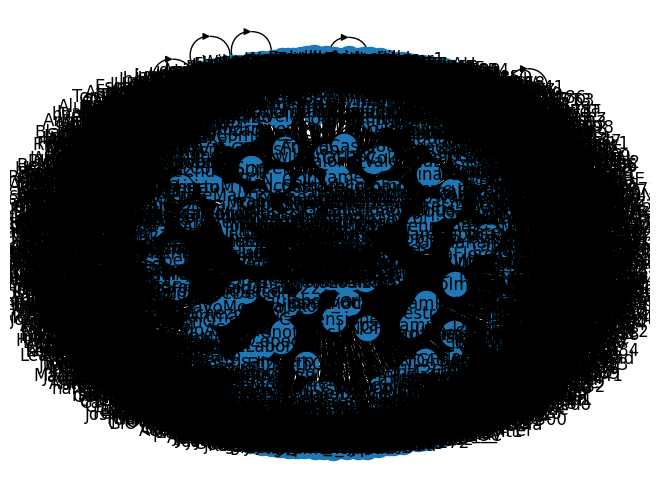

In [34]:
import networkx as nx

mentions_G = nx.from_pandas_adjacency(mentions_df, create_using=nx.DiGraph(directed=True))
nx.draw(mentions_G, with_labels=True)
nx.write_gexf(mentions_G, "mentions.gexf")

<H1>Estimación de la influecia global de cada usuario</H1>

In [35]:
globalInfluence: ndarray[int] = np.ones(n, int)
metrics_keys: list[str] = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'bookmarks_count',
                           'impressions_count']
for index, row in df.iterrows():
    author: str = row['author_username']  #usuario que escribió el tweet
    author_idx: int = user_index[author]
    tweet_metrics: dict[str, int] = literal_eval(row['public_metrics'])
    n_retweets, n_replies, n_likes, n_quotes, n_bookmarks, n_impressions = (
        tweet_metrics.get(key, 0) for key in metrics_keys)
    globalInfluence[author_idx] += 3 * (n_retweets + n_quotes + n_replies) + 2 * (
            n_likes + n_bookmarks) + n_impressions + 1
globalInfluence

array([10922,  7112,  5774, ...,     2,     9, 10403])

In [36]:
localInfluence:ndarray[float] = np.ones(n, float)
for i in range(n):
    mentions_matrix[i, i] = 0
    comunity_influence:int = np.sum(
        globalInfluence[mentions_matrix[i] != 0])  # Encuentra los nodos con los que el nodo i ha interactuado
    localInfluence[i] = globalInfluence[i] / (comunity_influence + globalInfluence[i]) if comunity_influence else 0

localInfluence_matrix:ndarray[ndarray[float]] = mentions_matrix * localInfluence[:, np.newaxis]
localInfluence_G = nx.from_numpy_array(localInfluence_matrix, create_using=nx.DiGraph(directed=True))
nx.relabel_nodes(localInfluence_G, {index: user for user, index in user_index.items()}, copy=False)
nx.write_gexf(localInfluence_G, "localInfluence.gexf")

In [37]:
globalInfluence_matrix = mentions_matrix * globalInfluence[:, np.newaxis]
globalInfluence_df = pd.DataFrame(globalInfluence_matrix, index=user_array, columns=user_array)
globalInfluence_df

,LondonoLen81165,ivansan,gesuriberg,Ricrod18,XaraTormenta,ExtraColombia,AngaritaVergara,ESaenzRovner,Intidelaho2,SarayGonzalez95,...,inemartz,CristoBustos,PocoRabonne,gustavogomezlo1,LopeAugusto,ObservatorioHi2,MelodyL37022025,Osaqui12Oscar,Tolima66,henryro07695774
LondonoLen81165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ivansan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gesuriberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ricrod18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XaraTormenta,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ObservatorioHi2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MelodyL37022025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Osaqui12Oscar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tolima66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


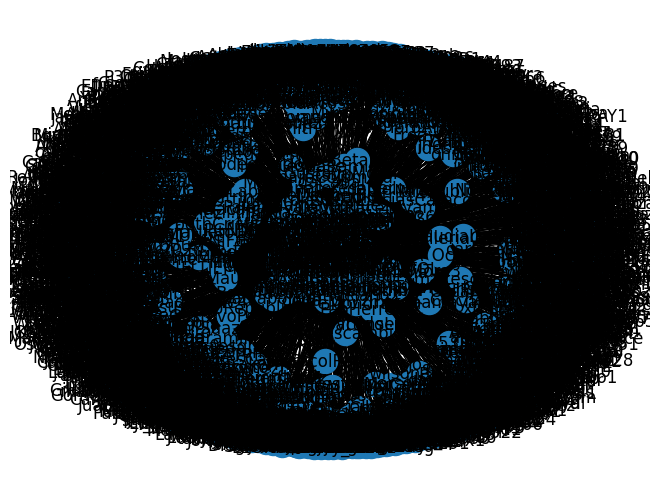

In [38]:
globalInfluence_G = nx.from_pandas_adjacency(globalInfluence_df, create_using=nx.DiGraph(directed=True))
nx.draw(globalInfluence_G, with_labels=True)
nx.write_gexf(globalInfluence_G, "globalInfluence.gexf")

<h1>Estimación de la afinidad entre usuarios 

In [39]:
users_tweet_text = [set() for _ in range(n)]
for index, row in df.iterrows():
    author = row['author_username']  #usuario propietario el tweet
    author_idx = user_index[author]

    if row['ref_type'] == "tweeted":
        users_tweet_text[author_idx].add(row['text'])
        continue

    ref_author = row['ref_author']  #usuario que redactó el tweet que fue retweeteado, 
    ref_author_idx = user_index[ref_author] if ref_author else None

    if row['ref_type'] == "retweeted":
        tweet_text = row['ref_note_tweet'] if row['ref_note_tweet'] else row['ref_text']
        users_tweet_text[author_idx].add(tweet_text)
        if ref_author_idx is not None:
            users_tweet_text[ref_author_idx].add(tweet_text)
        continue

    if row['ref_type'] == "quoted" or row['ref_type'] == "replied_to":
        users_tweet_text[author_idx].add(row['text'])
        ref_tweet_text = row['ref_note_tweet'] if row['ref_note_tweet'] else row['ref_text']
        if ref_author_idx is not None:
            users_tweet_text[ref_author_idx].add(ref_tweet_text)
        users_tweet_text[author_idx].add(row['text'])
        continue


In [53]:
import re
import emoji

def cleanText(text: str) -> str:
    text = re.sub(r'http\S+|www\S+', '', text) #urls
    #text = re.sub(r'@\w+', '', text) #menciones
    text = emoji.demojize(text, language="es")
    return text
print(cleanText("@petrogustavo: Hola https://chatgpt.com/c/67081020-548c-8010-ae5d-6abb221a2f28 en esta url se puede ver como nos utilizan 🤬"))

@petrogustavo: Hola  en esta url se puede ver como nos utilizan :cara_con_sÃ­mbolos_en_la_boca:


In [48]:
from pysentimiento import create_analyzer
from sentence_transformers import SentenceTransformer
from functools import cache

analyzer = create_analyzer(task="sentiment", lang="es")
model2 = SentenceTransformer('jaimevera1107/all-MiniLM-L6-v2-similarity-es')


@cache
def getEmbeddings(text: str):
    return model2.encode(text)


@cache
def getPolarity(text: str) -> float:
    prediction = analyzer.predict(text)
    NEG, NEU, POS = prediction.probas["NEG"], prediction.probas["NEU"], prediction.probas["POS"]
    polarity = round(POS - NEG, 3)
    return polarity


users_afinity = np.zeros((n, n), float)
edges_influence_stance = {}
for i, userInfluence in globalInfluence_df.iterrows():
    user_idx_i: int = user_index[i]
    for j, interPersonalInfluence in userInfluence.items():
        if interPersonalInfluence != 0:
            user_idx_j: int = user_index[j]

            user_i_opinions = list(users_tweet_text[user_idx_i])
            user_j_opinions = list(users_tweet_text[user_idx_j])
            embeddings_user_i: list[float] = [getEmbeddings(opinion) for opinion in user_i_opinions]
            embeddings_user_j: list[float] = [getEmbeddings(opinion) for opinion in user_j_opinions]
            afinity_ij = []
            stence_afinity_ij = []
            if len(embeddings_user_i) > 0 and len(embeddings_user_j) > 0:
                for index_i, opinions_similarity_i in enumerate(
                        model2.similarity(embeddings_user_i, embeddings_user_j)):
                    opinion_i = user_i_opinions[index_i]
                    opinion_polarity_i = getPolarity(opinion_i)
                    for index_j, opinion_similarity_ij in enumerate(opinions_similarity_i):
                        opinion_j = user_j_opinions[index_j]
                        opinion_polarity_j = getPolarity(opinion_j)
                        polarity_similarity = (2 - abs(opinion_polarity_i - opinion_polarity_j)) / 2
                        opinion_afinity = opinion_similarity_ij * polarity_similarity
                        afinity_ij.append(opinion_afinity)
                        diff_polarity: int = (1 if opinion_polarity_i >= 0 else -1) * (
                            1 if opinion_polarity_j >= 0 else -1)
                        stence_afinity_ij.append(diff_polarity)
                afinity_users_ij: float = sum(afinity_ij) / len(afinity_ij)
                users_afinity[user_idx_i, user_idx_j] = afinity_users_ij
                edges_influence_stance[(i, j)] = "A favor" if stence_afinity_ij.count(1) > 2 * len(
                    stence_afinity_ij) // 3 else "En contra"
                #print(stence_afinity_ij, stence_afinity_ij.count(1), 2*len(stence_afinity_ij)//3)
                #print(i,j, len(user_i_opinions), len(user_j_opinions), afinity_users_ij, user_idx_i, user_idx_j)
users_afinity

C:\Users\jujov\TG_code\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
user_index["petrogustavo"], user_index["JULIOTORRESB3"], users_afinity[
    user_index["petrogustavo"], user_index["JULIOTORRESB3"]]

(507, 2141, np.float64(0.16800491511821747))

In [42]:
users_afinity_G = nx.from_numpy_array(users_afinity, create_using=nx.DiGraph(directed=True))
nx.relabel_nodes(users_afinity_G, {index: user for user, index in user_index.items()}, copy=False)
nx.set_edge_attributes(users_afinity_G, edges_influence_stance, "influenceStance")
nx.write_gexf(users_afinity_G, "users_influence.gexf")

In [43]:
getPolarity("Estoy completamente en contra de la reforma pensional.")

-0.905